In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import seaborn as sns
import tensorflow as tf
import os

# Necessário mudar o diretório de trabalho para o nível mais acima
if not 'notebooks' in os.listdir('.'):
    current_dir = os.path.abspath(os.getcwd())
    parent_dir = os.path.dirname(current_dir)
    os.chdir(parent_dir)

from src.model import Arima, ModelFactory
from src.util import plot_heatmap, temporal_train_val_test2

seed = 32
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Paired"))

tf.get_logger().setLevel('ERROR')
# my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
# tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

In [2]:
dataset_path = 'data/tiny-dataset.hdf5'

with h5py.File(dataset_path, 'r') as in_:
    data = in_['real'][...]

In [3]:
x = data[:, :-1]
y = data[:, 1:]

num_models = 25
test_size = .1
val_size = .2

model_name_prefix = 'arima'
output_dir = os.path.join(parent_dir, 'saved_models_arima')

In [4]:
model_factory = ModelFactory(model_class=Arima, x=x, f_x=y, num_models=num_models,
                             test_size=test_size, val_size=val_size,
                             model_name_prefix=model_name_prefix,
                             model_kwargs=dict(u=0, 
                                               optimizer=tf.keras.optimizers.Adam(), 
                                               early_stopping_min_delta=1e-8,
                                               early_stopping_patience=50),
                             train_val_test_splitter=temporal_train_val_test2)

In [5]:
model_factory.build_models()
model_factory.fit_models()

Building models: 100%|██████████| 25/25 [00:00<00:00, 105.11it/s]
Training models: 25it [01:01,  2.45s/it]


Building metric matrices: 25it [00:25,  1.01s/it]


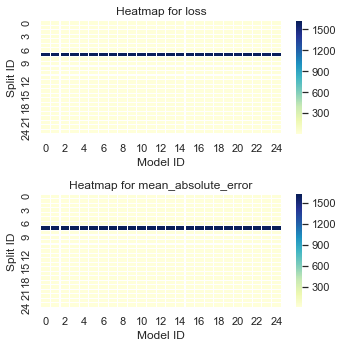

In [6]:
info = model_factory.get_metric_info()

num_metrics = len(info.keys())
fig, axs = plt.subplots(num_metrics, 1)
fig.set_size_inches(5, 5)
for i, (key, value) in enumerate(info.items()):
    plot_heatmap(matrix=value.matrix, title=f'Heatmap for {key}', 
                 x_label='Model ID', y_label='Split ID', ax=axs[i])
fig.tight_layout()

In [7]:
model_factory.save_models(output_dir)
model_factory.save_data(output_dir)